Perform statistical analyses of metrics computed in 3A.

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

from disp import set_font_size


LOAD_DIR = 'data_/_RESULTS/ODOR_TRACKING'
SAVE_DIR = 'data_/_RESULTS/ODOR_TRACKING_STATS'
EXPT = 'CL_360_LOWFLOW_ACV'
# EXPT = 'CL_180_HighFlow_ACV'

OFFSET = 'OFFSET_-30'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Quick sanity check

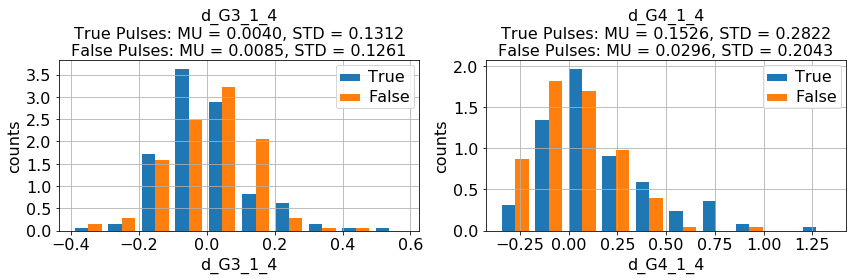

In [2]:
# distribution of G3 and G4 responses to odor
metrics = pd.read_csv(os.path.join(LOAD_DIR, '{}_METRICS.csv'.format(EXPT)), index_col=0)
metrics_ctl = pd.read_csv(
    os.path.join(LOAD_DIR, '{}_METRICS_FALSE_ODOR_{}.csv'.format(EXPT, OFFSET)), index_col=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

for ax, k in zip(axs, ['d_G3_1_4', 'd_G4_1_4']):
    
    ax.hist(np.array([metrics[k], metrics_ctl[k]]).T, normed=True)
    ax.set_xlabel(k)
    ax.set_ylabel('counts')
    ax.set_title('{4}\nTrue Pulses: MU = {0:.4f}, STD = {1:.4f}\nFalse Pulses: MU = {2:.4f}, STD = {3:.4f}'.format(
        np.nanmean(metrics[k]), np.nanstd(metrics[k]),
        np.nanmean(metrics_ctl[k]), np.nanstd(metrics_ctl[k]), k))
    ax.legend(['True', 'False'])


for ax in axs:
    ax.grid()
    set_font_size(ax, 16)

In [3]:
metrics.columns

Index(['Trial', 'On', 'Off', 'Include', 'G2_neg10_0', 'G2_neg10_0_mv',
       'G3_neg10_0', 'G3_neg10_0_mv', 'G4_neg10_0', 'G4_neg10_0_mv',
       'G5_neg10_0', 'G5_neg10_0_mv', 'd_G2_1_4', 'd_G2_1_4_mv', 'd_G3_1_4',
       'd_G3_1_4_mv', 'd_G4_1_4', 'd_G4_1_4_mv', 'd_G5_1_4', 'd_G5_1_4_mv',
       'd_h_1_4', 'd_h_1_4_mv', 'd_h_7_10', 'd_h_7_10_mv', 'd_v_1_4',
       'd_v_1_4_mv', 'd_v_7_10', 'd_v_7_10_mv', 'h_neg10_0', 'h_neg10_0_mv',
       'v_neg10_0', 'v_neg10_0_mv', 'x_c_1', 'x_c_2', 'x_c_3', 'x_c_4', 'y_c'],
      dtype='object')

# Nested model analysis

Explaining neural.

In [4]:
factors = ['None', 'h_neg10_0', 'd_v_1_4', 'd_h_1_4', 'd_h_7_10']

for mode in ['ODOR', 'CONTROL']:

    if mode == 'ODOR':
        metrics_filt = metrics[metrics['Include'] == 'Include'].dropna()
    elif mode == 'CONTROL':
        metrics_filt = metrics_ctl[metrics['Include'] == 'Include'].dropna()
        
    for gx in ['G2', 'G3', 'G4', 'G5']:

        print('{}:'.format(gx))

        targ = 'd_{}_1_4'.format(gx)
        y = metrics_filt[targ]

        # reduced factors
        factors_r = []

        # track residual variances, f-vals, and p-vals
        res_vars = [np.nanvar(y)]
        fs = [np.nan]
        ps = [np.nan]

        for ctr, factor in enumerate(factors[1:]):

            # fit reduced model
            if ctr == 0:
                y_hat_r = np.nanmean(y)
            else:
                xs_r = metrics_filt[factors_r]
                rgr_r = linear_model.LinearRegression().fit(xs_r, y)
                y_hat_r = rgr_r.predict(xs_r)

            # fit full model
            factors_f = factors_r + [factor]
            xs_f = metrics_filt[factors_f]
            rgr_f = linear_model.LinearRegression().fit(xs_f, y)
            y_hat_f = rgr_f.predict(xs_f)

            print('CTR = {}'.format(ctr))
            print('FACTORS_R = {}'.format(factors_r))
            print('FACTORS_F = {}'.format(factors_f))

            # calc variance of residual 
            res_var = np.nanvar(y - y_hat_f)
            res_vars.append(res_var)

            # calc f & p val btwn reduced and full
            n = len(y)

            rss_r = np.sum((y - y_hat_r)**2)
            rss_f = np.sum((y - y_hat_f)**2)

            # params
            p_r = ctr + 1
            p_f = ctr + 2

            # degs freedom
            dfn = p_f - p_r
            dfd = n - p_f

            # compute F
            f = ((rss_r - rss_f) / (p_f - p_r)) / (rss_f / (n - p_f))

            # compute p_val
            p = stats.f.sf(f, dfn, dfd)

            fs.append(f)
            ps.append(p)

            # make current full factor set be next reduced factor set
            factors_r = factors_f

        print('P = {}'.format(ps))

        df_save = pd.DataFrame(
            data={'FACTORS': factors, 'RES_VAR': res_vars, 'F': fs, 'P': ps},
            columns=['FACTORS', 'RES_VAR', 'F', 'P'])

        if mode == 'ODOR':
            fn = '{}_{}_FROM_NESTED.csv'.format(EXPT, targ)
        elif mode == 'CONTROL':
            fn = '{}_{}_FROM_NESTED_CTL_{}.csv'.format(EXPT, targ, OFFSET)
            
        df_save.to_csv(os.path.join(SAVE_DIR, fn), index=False, na_rep='NaN')

G2:
CTR = 0
FACTORS_R = []
FACTORS_F = ['h_neg10_0']
CTR = 1
FACTORS_R = ['h_neg10_0']
FACTORS_F = ['h_neg10_0', 'd_v_1_4']
CTR = 2
FACTORS_R = ['h_neg10_0', 'd_v_1_4']
FACTORS_F = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4']
CTR = 3
FACTORS_R = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4']
FACTORS_F = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4', 'd_h_7_10']
P = [nan, 0.013617839018961233, 0.017568832398522045, 0.2781917189226873, 0.0017363089807892699]
G3:
CTR = 0
FACTORS_R = []
FACTORS_F = ['h_neg10_0']
CTR = 1
FACTORS_R = ['h_neg10_0']
FACTORS_F = ['h_neg10_0', 'd_v_1_4']
CTR = 2
FACTORS_R = ['h_neg10_0', 'd_v_1_4']
FACTORS_F = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4']
CTR = 3
FACTORS_R = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4']
FACTORS_F = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4', 'd_h_7_10']
P = [nan, 0.1426534762365219, 0.9183576948390828, 0.5833248673310791, 0.00136226754477974]
G4:
CTR = 0
FACTORS_R = []
FACTORS_F = ['h_neg10_0']
CTR = 1
FACTORS_R = ['h_neg10_0']
FACTORS_F = ['h_neg10_0', 'd_v_1_4']
CTR = 2
FACTORS_R = ['

## Make plots

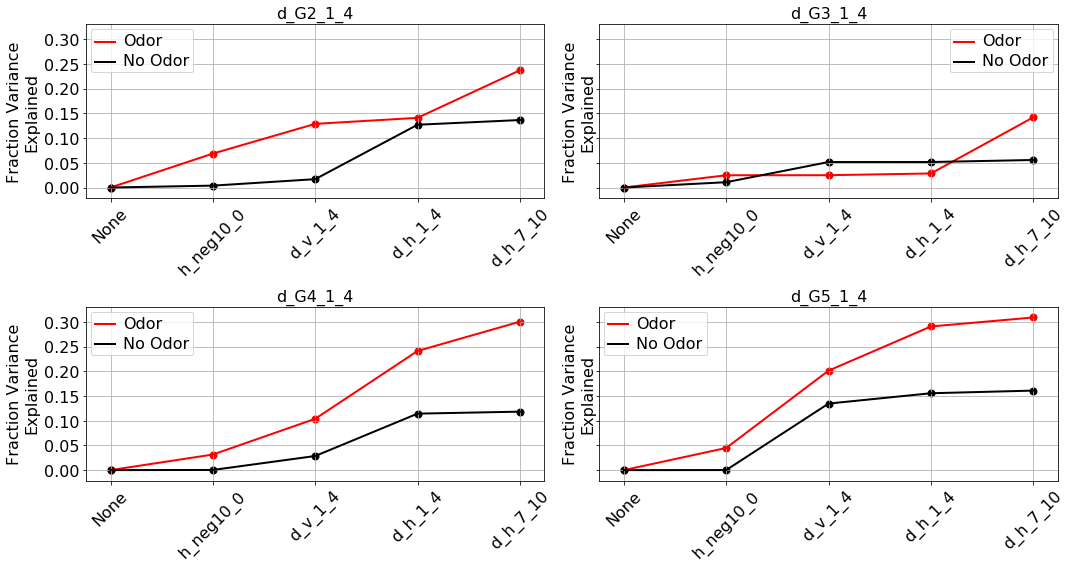

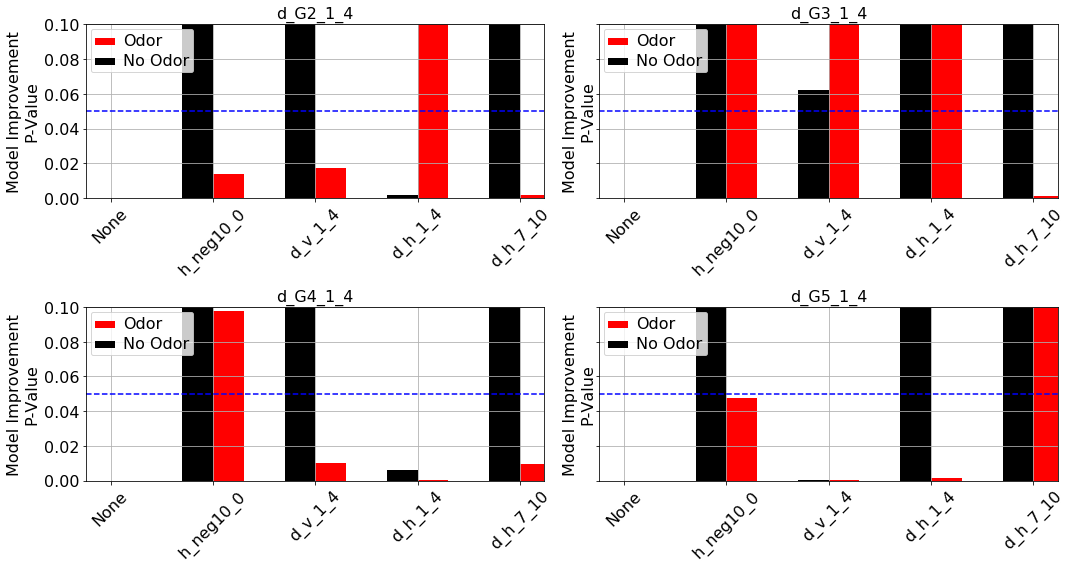

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), tight_layout=True, sharey=True)
fig_p, axs_p = plt.subplots(2, 2, figsize=(15, 8), tight_layout=True, sharey=True)

for ax, ax_p, gx in zip(axs.flat, axs_p.flat, ['G2', 'G3', 'G4', 'G5']):
    targ = 'd_{}_1_4'.format(gx)
    
    # explained variance
    
    ## true
    df = pd.read_csv(os.path.join(SAVE_DIR, '{}_{}_FROM_NESTED.csv'.format(EXPT, targ)))
    
    ## control
    df_ctl = pd.read_csv(os.path.join(SAVE_DIR, '{}_{}_FROM_NESTED_CTL_{}.csv'.format(EXPT, targ, OFFSET)))
    
    var = df['RES_VAR']
    var = (1 - var/var.max())
    
    ax.plot(np.arange(len(df)), var, color='r', lw=2)
    ax.scatter(np.arange(len(df)), var, color='r', lw=2)
    
    var_ctl = df_ctl['RES_VAR']
    var_ctl = (1 - var_ctl/var_ctl.max())
    
    ax.plot(np.arange(len(df)), var_ctl, color='k', lw=2)
    ax.scatter(np.arange(len(df)), var_ctl, color='k', lw=2)
    
    ax.set_xticks(np.arange(len(df)))
    ax.set_xticklabels(df['FACTORS'], rotation=45)
    
    ax.set_ylabel('Fraction Variance\nExplained')
    ax.set_title(targ)
    
    ax.legend(['Odor', 'No Odor'])
    
    ax.grid()
    set_font_size(ax, 16)
    
    # p-vals
    ax_p.bar(np.arange(len(df)), df['P'], align='edge', width=.3, color='r', lw=2)
    ax_p.bar(np.arange(len(df)), df_ctl['P'], align='edge', width=-.3, color='k', lw=2)
    ax_p.legend(['Odor', 'No Odor'], loc='upper left')
    
    ax_p.axhline(0.05, color='b', ls='--')
    
    ax_p.set_xlim(ax.get_xlim())
    ax_p.set_ylim(0, 0.1)
    
    ax_p.set_xticks(np.arange(len(df)))
    ax_p.set_xticklabels(df['FACTORS'], rotation=45)
    
    ax_p.set_ylabel('Model Improvement\nP-Value')
    ax_p.set_title(targ)
    
    ax_p.grid()
    set_font_size(ax_p, 16)
    
fig.savefig(os.path.join(SAVE_DIR, 'GX_FROM_NESTED.pdf'))
fig_p.savefig(os.path.join(SAVE_DIR, 'GX_FROM_NESTED_P.pdf'))

# Orienting figures

Plot example traces of odor-triggered DANs & behavior.

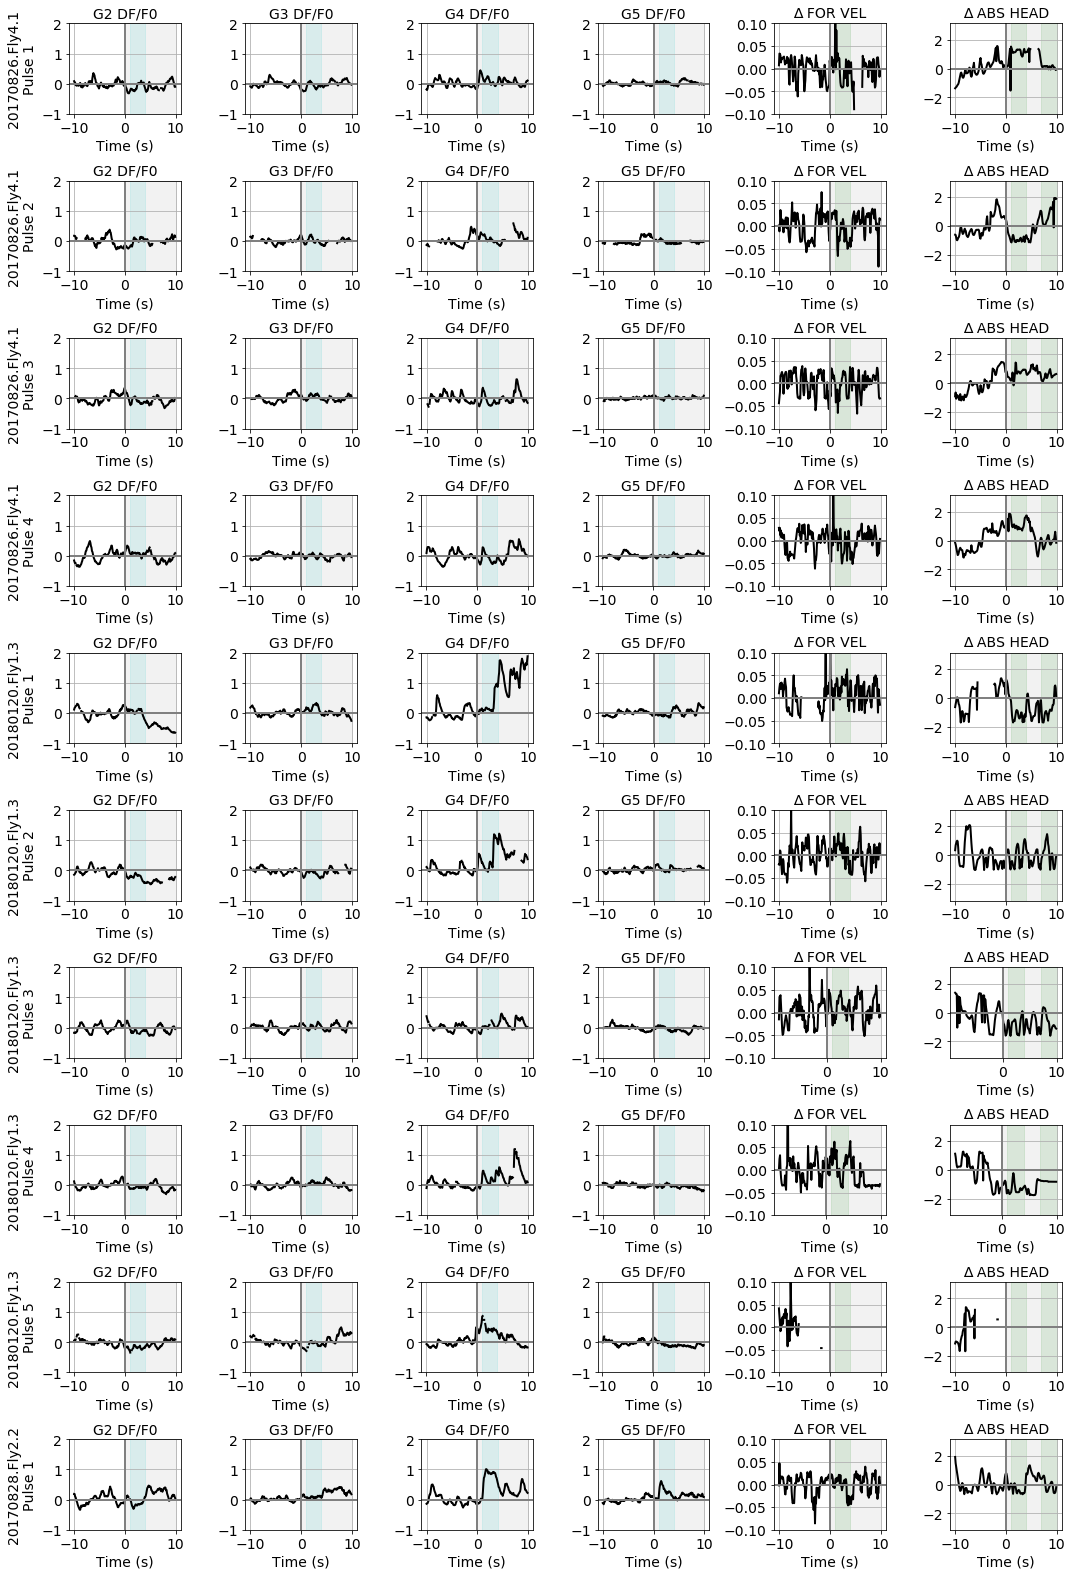

In [6]:
p_ids = range(10)
VARS = ['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5', 'DELTAFORVEL', 'DELTAABSHEADING']
labels = {
    'DFF0G2': 'G2 DF/F0',
    'DFF0G3': 'G3 DF/F0',
    'DFF0G4': 'G4 DF/F0',
    'DFF0G5': 'G5 DF/F0',
    'DELTAFORVEL': '∆ FOR VEL',
    'DELTAABSHEADING': '∆ ABS HEAD',
}

# load all data
dfs = {}
for var in VARS:
    dfs[var] = pd.read_csv(os.path.join(LOAD_DIR, 'ODOR_TRIG_{}.csv'.format(var)), index_col=0)
    
fig, axs = plt.subplots(len(p_ids), 6, figsize=(15, 2.2*len(p_ids)), tight_layout=True)

for ax_row, p_id in zip(axs, p_ids):
    trial = dfs[VARS[0]].loc[p_id]['Trial']
    p_ctr = dfs[VARS[0]].loc[p_id]['PulseCounter']
        
    for ctr, (ax, var) in enumerate(zip(ax_row, VARS)):
        
        trial_ = dfs[var].loc[p_id]['Trial']
        p_ctr_ = dfs[var].loc[p_id]['PulseCounter']
        
        assert trial_ == trial
        assert p_ctr_ == p_ctr
        
        t = dfs[var].columns[3:]
        ax.plot(t, dfs[var].loc[p_id][3:], color='k', lw=2)
        
        ax.axhline(0, color='gray', lw=2)
        ax.axvline(0, color='gray', lw=2)
        ax.axvspan(0, 10, color='gray', alpha=0.1)
        
        if var in ['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5']:
            ax.axvspan(1, 4, color='c', alpha=0.1)
            ax.set_ylim(-1, 2)
        elif var == 'DELTAFORVEL':
            ax.axvspan(1, 4, color='g', alpha=0.1)
            ax.set_ylim(-.1, .1)
        elif var == 'DELTAABSHEADING':
            ax.axvspan(1, 4, color='g', alpha=0.1)
            ax.axvspan(7, 10, color='g', alpha=0.1)
            ax.set_ylim(-np.pi, np.pi)
            
        ax.set_xlabel('Time (s)')
        
        if ctr == 0:
            ax.set_ylabel('{}\nPulse {}'.format(trial, p_ctr+1))
        ax.grid()
        ax.set_title(labels[var])
        
        set_font_size(ax, 14)
        
fig.savefig(os.path.join(SAVE_DIR, '{}_ODOR_TRIG_EXAMPLES.pdf'.format(EXPT)))